In [49]:
import torch
import torch.nn as nn
import os
from io import open
import glob
import unicodedata
import string
import numpy as np
import time
import math

In [50]:
data_path = './data/*.txt'

class LanguageDetect():
    def __init__(self, files_path='./data', limit_size=None):
        # scan language files
        lang_files = glob.glob(data_path)
        
        self.alphabet = string.ascii_lowercase + '.'
        self.n_alphabet = len(self.alphabet)# + 1
        self.wordlist = [] # words for all languages on the dataset
        self.categorylist = [] # list of categories of languages by index (int)
        self.classes = [] # classes of languages ('english', 'spanish'...)
        self.padding = 0

        idx = 0
        for file in lang_files:
            language = os.path.splitext(os.path.basename(file))[0]
            self.classes.append(language)
            words = self._transform_vocab(file, limit_size)
            self.wordlist += words
            self.categorylist += [idx for i in range(len(words))]
            idx += 1
        
        self.padding = len(max(self.wordlist, key=len)) # size of the largest string
           
    def _unicodeToAscii(self, s):
        all_letters = string.ascii_letters
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in all_letters)

    def _transform_vocab(self, vocab, limit_size):
        wordset = (open(vocab).read()).lower() # open file and convert letters to lowercase
        wordset = ''.join(i for i in wordset if (i.isalpha() | i.isspace())).split() # remove all non alpha and single characters thus split into a list
        wordset = [word for word in wordset if len(word) > 1] # remove single characters and spaces
        wordset = [self._unicodeToAscii(word) for word in wordset] # convert to ASCII
        wordset = list(set(wordset)) # list of unique elements
        if limit_size is not None:
            wordset = wordset[:limit_size]
        return wordset


   
    def __len__(self):
        return len(self.wordlist)
    
    def __getitem__(self, idx):
        word = self.wordlist[idx]
        
        # target is the word shifited by 1 character to the left
        target = [self.alphabet.find(word[i]) for i in range(1, len(word))]
        target.append(self.n_alphabet - 1)
        target = torch.LongTensor(target)
        
        # convert word and target to a tensor (len word x 1 x alphabet)
        word = word2tensor(word, self.alphabet, n_alphabet, padding=self.padding)
        
        # convert category to a tensor (len word x 1 x alphabet)
        i_category = self.categorylist[idx]
        category = category2tensor(i_category, classes)
        
        return category, word, target
        
        

In [51]:
def word2tensor(word, alphabet, n_alphabet, padding=None):
    if padding is not None:
        num_charac = padding # pad to the fill the size
    else:
        num_charac = len(word)
    len_word = len(word)
    wtensor = torch.zeros(num_charac, 1, n_alphabet)
    for iletter in range(len_word):
        wtensor[iletter][0][alphabet.find(word[iletter])] = 1
    return wtensor


def category2tensor(i_category, classes):
        category = torch.zeros(1, len(classes))
        category[0][i_category] = 1 
        return category
 

In [52]:
dataset = LanguageDetect(data_path, limit_size=100)
alphabet = dataset.alphabet
n_alphabet = dataset.n_alphabet
padding = dataset.padding

classes = dataset.classes
print('dataset size:', len(dataset))
print('classes:', classes)

dataset size: 200
classes: ['german', 'english']


In [53]:
print(type(dataset))
print(type(dataset[0]))
print(type(dataset[0][0]))
print(dataset[0][0].size())
alphabet[0]

<class '__main__.LanguageDetect'>
<class 'tuple'>
<class 'torch.Tensor'>
torch.Size([1, 2])


'a'

In [54]:
def tensor2word(tensor):
    alphabet = string.ascii_lowercase
    word = ''
    for i in range(tensor.size()[0]):
        for j in range(tensor.size()[2]):
            if tensor[i][0][j] == 1:
                word += alphabet[j]
    return word
        
def tensor2category(tensor):
    _, idxvalue = torch.topk(tensor, 1)
    return idxvalue.item()

def targettensor2word(tensor):
    word = ''
    for i in range(len(tensor)-1):
        word += alphabet[tensor[i]]
    return word
    
# dataset dim = |idx (category, word, target)
# first category
print('category:', dataset[0][0])
print('category:', tensor2category(dataset[0][0]))
#print('category:', dataset[0][0].size())

# first word
print('word:', tensor2word(dataset[0][1]))
# first target
print('target:', dataset[0][2])
print()

# sample example
sample_idx = np.random.randint(1, len(dataset))

print('random sample')
print('category tensor:', dataset[sample_idx][0])
print('category:', tensor2category(dataset[sample_idx][0]))
print('category class:', classes[tensor2category(dataset[sample_idx][0])])

print('word:', tensor2word(dataset[sample_idx][1]))
print('target:', targettensor2word(dataset[sample_idx][2]))

category: tensor([[1., 0.]])
category: 0
word: dazu
target: tensor([ 0, 25, 20, 26])

random sample
category tensor: tensor([[1., 0.]])
category: 0
category class: german
word: lichterfelde
target: ichterfelde


In [55]:
# split dataset
train_size = len(dataset)

# creating dataloaders
batch_size = 1

# create training data loader
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

### The model will be based on the following chart
![RNN model](./images/simplernn.png)

In [56]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_categories, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        #output = self.dropout(output)
        output = self.softmax(output)
        return hidden, output

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, category_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2o = nn.Linear(category_size+input_size+hidden_size, output_size)
        self.i2h = nn.Linear(category_size+input_size+hidden_size, hidden_size)
        self.o2o = nn.Linear(output_size+hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, last_hidden):
        hidden = self.i2h(torch.cat((category, input, last_hidden), dim=1))
        output = self.i2o(torch.cat((category, input, last_hidden), dim=1)) 
        out_combined = torch.cat((output, hidden), dim=1)
        output = self.o2o(out_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        
        return hidden, output
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [57]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using gpu:", use_cuda)

Using gpu: True


for cat, word, target in train_loader:
    print(cat)
    print(word)
    print(target)
    print('word:', tensor2word(word[0]))
    print('target:', targettensor2word(target[0]))
    break

In [58]:
# hidden NN size
hidden_size = 256

In [59]:
rnn = RNN(n_alphabet, hidden_size, len(classes), n_alphabet).to(device)

In [60]:
criterion = nn.NLLLoss()
learning_rate = 0.0005


optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

PATH_state_dict = './lang_gen.pth' # file to be stored the best weights of the trained model

In [61]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(model, criterion, learning_rate=0.0001, epochs=1000, plots_per_epoch=50):
    
    cost = []
    start_time = time.time()
    character_count = 0
    loss = 0
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        running_corrects = 0
        model.train()
        
        train_ct = 0
        for cat, word, target in train_loader:
            cat = cat[0].to(device)
            word = word[0].to(device)
            target = target[0].unsqueeze_(-1).to(device)

            
            hidden = model.initHidden().to(device)
            model.zero_grad()
            loss = 0
            loss_t = 0
            word_ct = 0

            for i in range(word.size()[0]): # go through each letter
                if torch.sum(word[i]) > 0: # avoid paddding
                    hidden, output = model(cat, word[i], hidden)

                    loss_t = criterion(output, target[i])
                    loss += loss_t # the loss is calculated for each character

                    _, guess = output.topk(1) # return the 1 largest element from output tensor
                    guess = guess[0].item()
                    if guess == int(target[i]):
                        running_corrects += 1
                else: break
                
            train_ct += i
            loss.backward()
           
            
            optimizer.step()
            running_loss += loss
            
        cost.append(running_loss)
        epoch_acc = running_corrects / train_ct
        
        if epoch % plots_per_epoch == 0:
            print('Epoch [{}] -> Loss: {:.4f}  Acc: {:.4f}'.format(
                epoch, running_loss/train_ct, epoch_acc))

    
    time_elapsed = time.time() - start_time
    print()
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    torch.save(model.state_dict(), PATH_state_dict)
    
    return model, cost

In [62]:
_, cost = train(rnn, criterion, learning_rate, epochs=1000)

Epoch [50] -> Loss: 1.3422  Acc: 0.5518
Epoch [100] -> Loss: 1.2609  Acc: 0.5557
Epoch [150] -> Loss: 0.9000  Acc: 0.6862
Epoch [200] -> Loss: 0.9527  Acc: 0.6569
Epoch [250] -> Loss: 1.3335  Acc: 0.5818
Epoch [300] -> Loss: 0.9259  Acc: 0.6585
Epoch [350] -> Loss: 0.8365  Acc: 0.7043
Epoch [400] -> Loss: 1.6849  Acc: 0.5447
Epoch [450] -> Loss: 0.7530  Acc: 0.7202
Epoch [500] -> Loss: 0.7568  Acc: 0.7257
Epoch [550] -> Loss: 0.8081  Acc: 0.6988
Epoch [600] -> Loss: 0.7238  Acc: 0.7336
Epoch [650] -> Loss: 0.6778  Acc: 0.7542
Epoch [700] -> Loss: 0.8172  Acc: 0.7020
Epoch [750] -> Loss: 0.6416  Acc: 0.7628
Epoch [800] -> Loss: 1.1817  Acc: 0.6300
Epoch [850] -> Loss: 0.6272  Acc: 0.7771
Epoch [900] -> Loss: 0.6283  Acc: 0.7715
Epoch [950] -> Loss: 0.8092  Acc: 0.7146
Epoch [1000] -> Loss: 0.6574  Acc: 0.7494

Training completed in 14m 55s


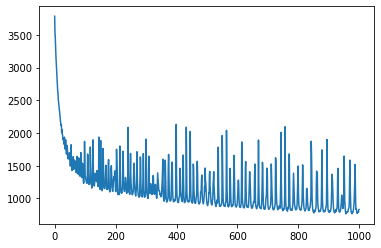

In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(cost)

In [64]:
def gen_word(model, i_category, classes, alphabet, n_alphabet, padding, start_letter='a'):
    max_size_word = 25
    model.eval() 
    
    word_generated = start_letter
    
    input_letter_t = word2tensor(start_letter, alphabet, n_alphabet, None).to(device)
    category_t = category2tensor(i_category, classes).to(device)
    hidden = torch.zeros(1, hidden_size).to(device)
    
   
    for i in range(max_size_word):
        hidden, output = model(category_t, input_letter_t[0], hidden)
        _, guess_i = output.topk(1)
        guess_i = guess_i[0][0]
        letter = alphabet[guess_i]
        
        if letter == '.': # if . (EOS) stop
            break
        else:
            word_generated += letter
        input_letter_t = word2tensor(letter, alphabet, n_alphabet, None).to(device)
        
    return word_generated
        

In [65]:
print(classes)
print(gen_word(rnn, 1, classes, alphabet, n_alphabet, padding, 'a'))

['german', 'english']
acquired
